# Anomaly Detection with FiftyOne and Anomalib

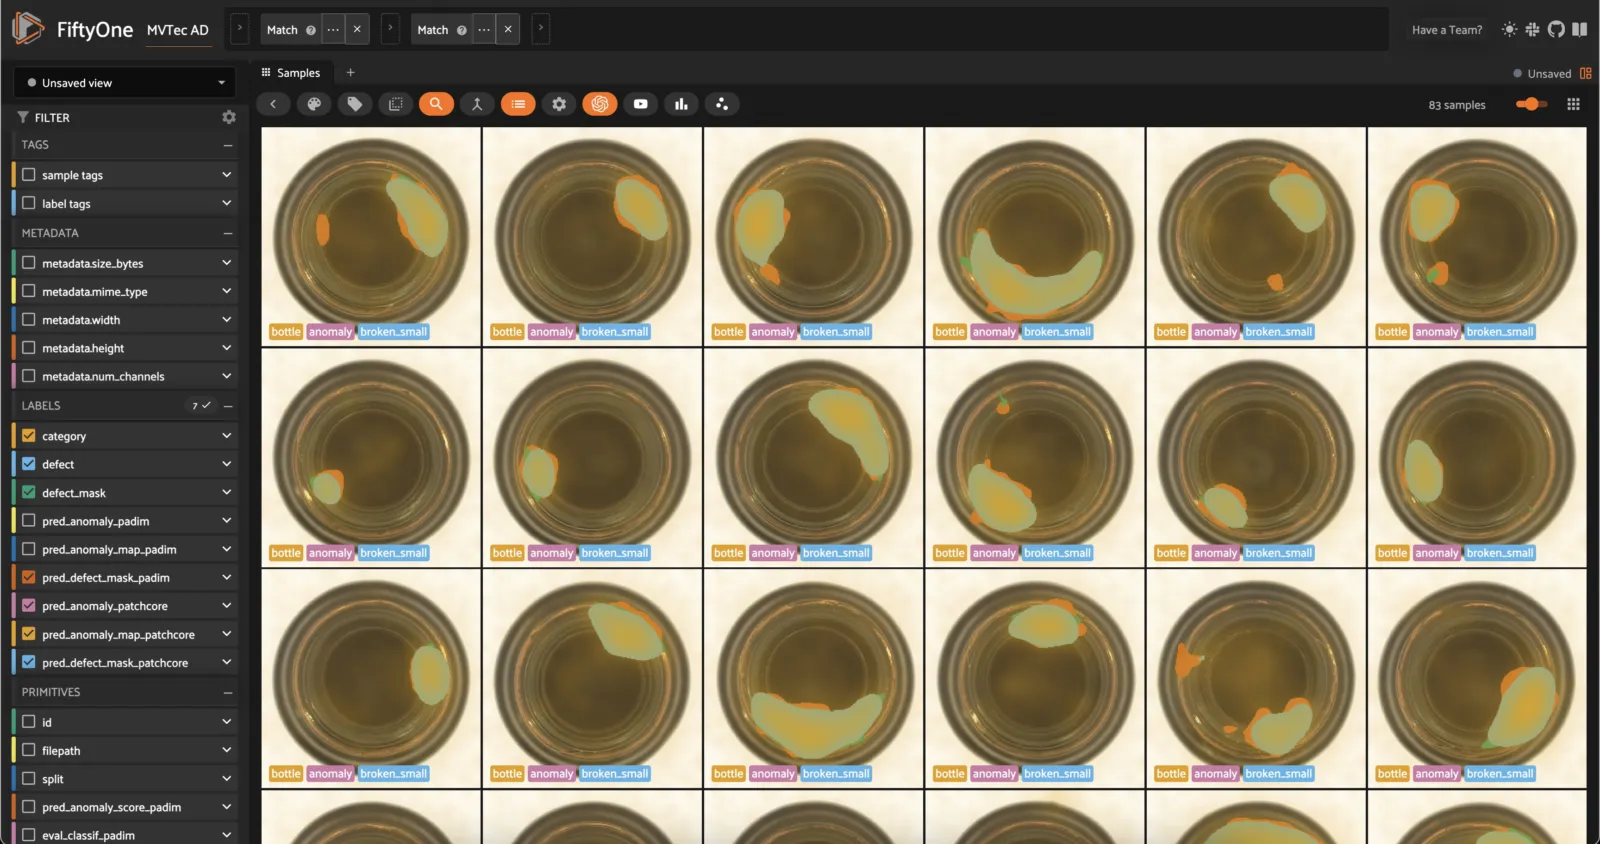

Anomaly detection (AD) is a crucial task in mission-critical applications such as fraud detection, network security, and medical diagnosis. Anomaly detection on *visual* data like images, videos, and satellite imagery, is a particularly challenging task due to the high dimensionality of the data and the complexity of the underlying patterns. Yet visual anomaly detection is essential for detecting defects in manufacturing, identifying suspicious activity in surveillance footage, and detecting abnormalities in medical images.

In this walkthrough, you'll learn how to perform anomaly detection on visual data using [FiftyOne](https://fiftyone.ai/) and [Anomalib](https://github.com/openvinotoolkit/anomalib) from the OpenVINO™ toolkit. We'll use the [MVTec AD dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad) for demonstration, which contains images of various objects with anomalies like scratches, dents, and holes.

The notebook covers the following:

- What is visual anomaly detection?
- Loading the MVTec AD dataset in FiftyOne
- Training an anomaly detection model with Anomalib
- Evaluating anomaly detection models in FiftyOne

## Setup

### Install dependencies

Make sure you are running this in a virtual environment with `python=3.10`. 

```bash
conda create -n anomalib_env python=3.10; conda activate anomalib_env
```

Anomalib requires Python 3.10, so make sure you have the correct version installed.

After this, install Anomalib and its dependencies. If you're running this in a colab notebook, the installation might take a few minutes, but local installation should be faster.

In [ ]:
!pip install -U torchvision einops FrEIA timm open_clip_torch imgaug lightning kornia openvino git+https://github.com/openvinotoolkit/anomalib.git

Install Anomalib from source, per the instructions in the [Anomalib README](https://github.com/openvinotoolkit/anomalib?tab=readme-ov-file#-installation)

If you don't have it already installed, install FiftyOne. Make sure your version is `fiftyone>=0.23.8` so we can use the [Hugging Face Hub integration](https://docs.voxel51.com/integrations/huggingface.html#huggingface-hub) to load the MVTec AD dataset:

In [ ]:
!pip install -U fiftyone

Just a few more packages to install, and we're ready to go. Now you can see why we recommend using a virtual environment for this project!

- `huggingface_hub` for loading the MVTec AD dataset
- `clip` for computing image embeddings
- `umap-learn` for dimensionality reduction

In [ ]:
!pip install -U huggingface_hub umap-learn git+https://github.com/openai/CLIP.git

### Load and Visualize the MVTec AD dataset

Now let's import all of the relevant modules we will need from FiftyOne:

In [1]:
import fiftyone as fo # base library and app
import fiftyone.brain as fob # ML methods
import fiftyone.zoo as foz # zoo datasets and models
from fiftyone import ViewField as F # helper for defining views
import fiftyone.utils.huggingface as fouh # Hugging Face integration

And load the [MVTec AD dataset from the Hugging Face Hub](https://huggingface.co/datasets/Voxel51/mvtec-ad):

In [ ]:
dataset = fouh.load_from_hub("Voxel51/mvtec-ad", persistent=True, overwrite=True)

💡 It is also possible to load the MVTec AD data directly from Anomalib:

```python
from anomalib.data import MVTec
datamodule = MVTec()
```

But this way we have all of the metadata and annotations in FiftyOne, which is useful for visualization and evaluation.

Before moving on, let's take a look at the dataset in the [FiftyOne App](https://docs.voxel51.com/user_guide/app.html):

In [ ]:
session = fo.launch_app(dataset)

The dataset has 5354 images across 12 object categories. Each category has "good" images and "anomalous" images with defects like scratches, dents, and holes. Each of the anomalous samples also has a mask which localizes the defective regions of the image. 

The defect labels differ across categories, which is typical in real-world anomaly detection scenarios. In typical anomaly detection scenarios, you train a different model for each category. Here we'll go through the process for one category, and you can apply the same steps to other categories.

One more thing to note is that the dataset is split into training and test sets. The training set contains only "good" images, while the test set contains both "good" and "anomalous" images.

Before we train a model, let's dig into the dataset a bit more. We can get a feel for the structure and patterns hidden in our data by computing image embeddings and visualizing them in a lower-dimensional space. First, we'll compute embeddings for all the images in the dataset using the [CLIP model](https://github.com/openai/CLIP):

In [ ]:
model = foz.load_zoo_model(
    "clip-vit-base32-torch"
)  # load the CLIP model from the zoo

# Compute embeddings for the dataset
dataset.compute_embeddings(
    model=model, embeddings_field="clip_embeddings", batch_size=64
)

# Dimensionality reduction using UMAP on the embeddings
fob.compute_visualization(
    dataset, embeddings="clip_embeddings", method="umap", brain_key="clip_vis"
)

Refresh the FiftyOne App, click the "+" tab, and select "Embeddings". Choose "all_clip_vis" from the dropdown menu. You'll see a scatter plot of the image embeddings in a 2D space, where each point corresponds to a sample in the dataset. Using the color-by dropdown, notice how the embeddings cluster based on the object category. This is because CLIP encodes semantic information about the images. Also note that *within* a category, CLIP embeddings don't cluster based on the defect type.

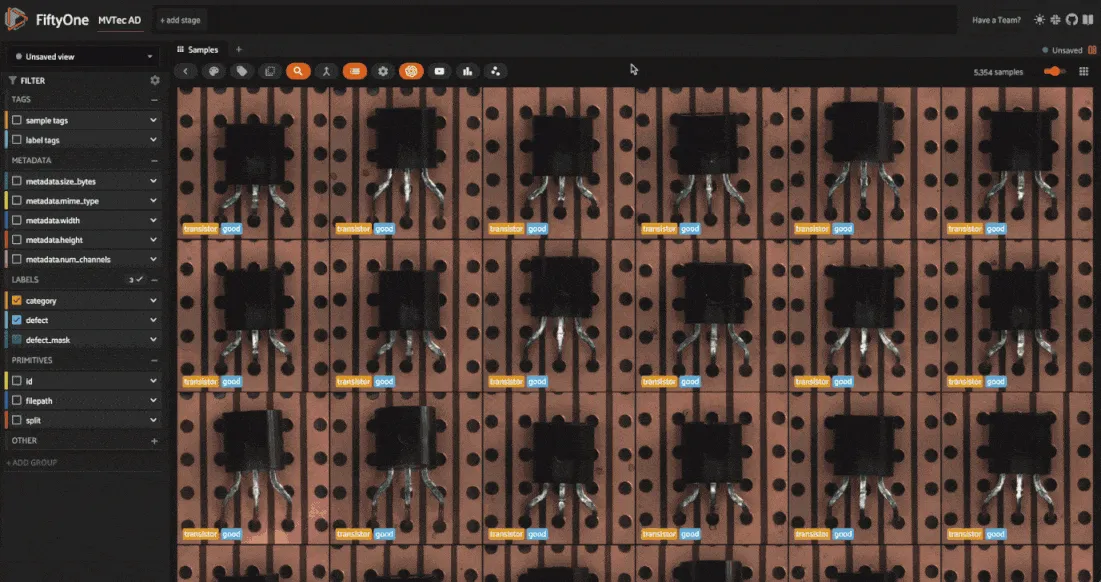

If instead we embed our images using a traditional computer vision model like ResNet, we also see some clustering within a category based on the defect type. However, as we established earlier, we will not have access to defect labels during inference. Instead, we'll use an unsupervised anomaly detection model.

In [ ]:
model = foz.load_zoo_model(
    "resnet50-imagenet-torch"
)  # load the ResNet50 model from the zoo

# Compute embeddings for the dataset — this might take a while on a CPU
dataset.compute_embeddings(model=model, embeddings_field="resnet50_embeddings")

# Dimensionality reduction using UMAP on the embeddings
fob.compute_visualization(
    dataset,
    embeddings="resnet50_embeddings",
    method="umap",
    brain_key="resnet50_vis",
)

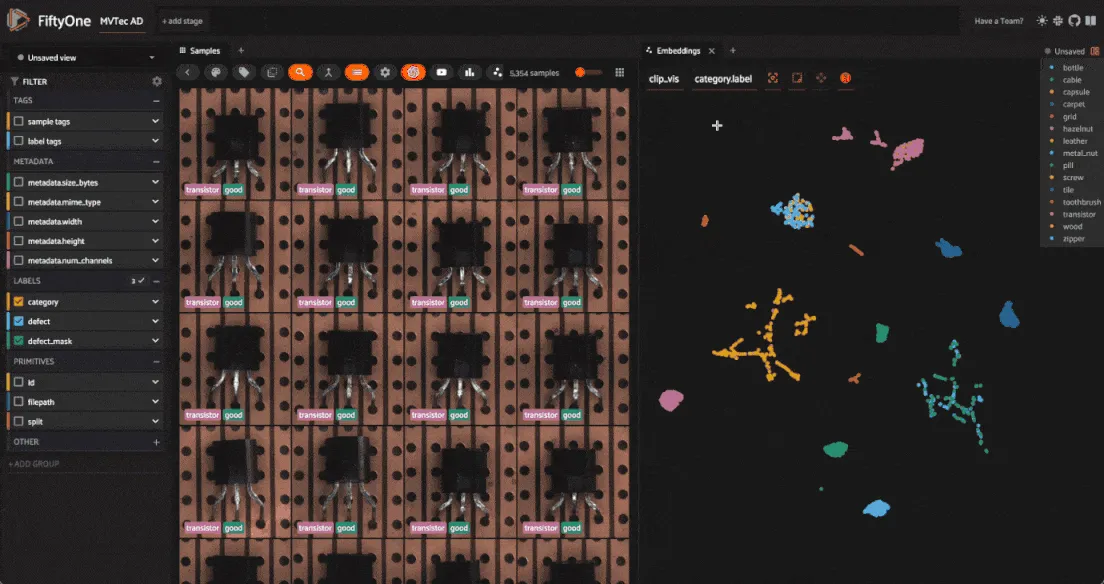

💡 For deep dives into embeddings and dimensionality reduction, check out our tutorials:

- [Using Image Embeddings](https://docs.voxel51.com/tutorials/image_embeddings.html)
- [Visualizing Data with Dimensionality Reduction Techniques](https://docs.voxel51.com/tutorials/dimension_reduction.html)

## Train an Anomaly Detection Model

Now that we have a sense of the dataset, we're ready to train an anomaly detection model using Anomalib. 

**Task**: Anomalib supports classification, detection, and segmentation tasks for images. We'll focus on segmentation, where the model predicts whether each pixel in the image is anomalous or not, creating a mask that localizes the defect.

**Model**: Anomalib supports a variety of anomaly detection algorithms, including [Deep Feature Kernel Density Estimation (DFKDE)](https://anomalib.readthedocs.io/en/v1.0.1/markdown/guides/reference/models/image/dfkde.html), [FastFlow](https://arxiv.org/abs/2111.07677), and [Reverse Distillation](https://arxiv.org/abs/2201.10703v2). For a complete list of supported algorithms, check out [Anomalib's reference guide](https://anomalib.readthedocs.io/en/v1.0.1/markdown/guides/reference/models/image/index.html). For this walkthrough, we'll use two algorithms:

- [PaDiM: a Patch Distribution Modeling Framework for Anomaly Detection and Localization](https://arxiv.org/abs/2011.08785)
- [PatchCore: Towards Total Recall in Industrial Anomaly Detection](https://arxiv.org/abs/2106.08265)

**Preprocessing**: For this walkthrough, we will resize the images to 256x256 pixels before training the model. Adding this as a transform via Torchvision's `Resize` class lets us resize the images on-the-fly during training and inference.

Import the necessary modules from Anomalib and helper modules for processing images and paths:

In [15]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
from torchvision.transforms.v2 import Resize

In [ ]:
from anomalib import TaskType
from anomalib.data.image.folder import Folder
from anomalib.deploy import ExportType, OpenVINOInferencer
from anomalib.engine import Engine
from anomalib.models import Padim, Patchcore

Now define some constants to use throughout the notebook.

- `OBJECT`: The object category we'll focus on. For this walkthrough, we'll use "bottle". If you want to loop over categories, you can get the list of categories from the dataset with `dataset.distinct("category.label")`.
- `ROOT_DIR`: The root directory where Anomalib will look for images and masks. Our data is already stored on disk, so we will just symlink files to the directory Anomalib expects.
- `TASK`: The task we're performing. We'll use "segmentation" for this walkthrough.
- `IMAGE_SIZE`: The size to resize images to before training the model. We'll use $256$ x $256$ pixels.

In [17]:
OBJECT = "bottle" ## object to train on
ROOT_DIR = Path("/tmp/mvtec_ad") ## root directory to store data for anomalib
TASK = TaskType.SEGMENTATION ## task type for the model
IMAGE_SIZE = (256, 256) ## preprocess image size for uniformity

For a given object type (category), the `create_datamodule()` function below creates an Anomalib  `DataModule` object. This will get passed into our engine's `fit()` method to train the model, and will be used to instantiate dataloaders for training and validation.

The code might look complex, so let's break down what's going on:

- We create subsets of our data containing only the "good" training images and "anomalous" images for validation.
- We symlink the images and masks to the directory Anomalib expects.
- We instantiate and setup a datamodule from Anomalib's `Folder`, which is the general-purpose class for custom datasets.

💡 It is also possible to create a torch `DataLoader` from scratch and pass it to the engine's `fit()` method. This gives you more control over the data loading process. This is left as an exercise for the reader 😉.

In [21]:
def create_datamodule(object_type, transform=None):
    ## Build transform
    if transform is None:
        transform = Resize(IMAGE_SIZE, antialias=True)

    normal_data = dataset.match(F("category.label") == object_type).match(
        F("split") == "train"
    )
    abnormal_data = (
        dataset.match(F("category.label") == object_type)
        .match(F("split") == "test")
        .match(F("defect.label") != "good")
    )

    normal_dir = Path(ROOT_DIR) / object_type / "normal"
    abnormal_dir = ROOT_DIR / object_type / "abnormal"
    mask_dir = ROOT_DIR / object_type / "mask"

    # create directories if they do not exist
    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(abnormal_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    if not os.path.exists(str(normal_dir)):
        normal_data.export(
            export_dir=str(normal_dir),
            dataset_type=fo.types.ImageDirectory,
            export_media="symlink",
        )

    for sample in abnormal_data.iter_samples():
        base_filename = sample.filename
        dir_name = os.path.dirname(sample.filepath).split("/")[-1]
        new_filename = f"{dir_name}_{base_filename}"
        if not os.path.exists(str(abnormal_dir / new_filename)):
            os.symlink(sample.filepath, str(abnormal_dir / new_filename))

        if not os.path.exists(str(mask_dir / new_filename)):
            os.symlink(sample.defect_mask.mask_path, str(mask_dir / new_filename))

    datamodule = Folder(
        name=object_type,
        root=ROOT_DIR,
        normal_dir=normal_dir,
        abnormal_dir=abnormal_dir,
        mask_dir=mask_dir,
        task=TASK,
        transform=transform
    )
    datamodule.setup()
    return datamodule

Now we can put it all together. The `train_and_export_model()` function below trains an anomaly detection model using Anomalib's `Engine` class, exports the model to OpenVINO, and returns the model "inferencer" object. The inferencer object is used to make predictions on new images.

In [19]:
def train_and_export_model(object_type, model, transform=None):
    engine = Engine(task=TASK)
    datamodule = create_datamodule(object_type, transform=transform)
    engine.fit(model=model, datamodule=datamodule)

    engine.export(
        model=model,
        export_type=ExportType.OPENVINO,
    )
    output_path = Path(engine.trainer.default_root_dir)


    openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
    metadata = output_path / "weights" / "openvino" / "metadata.json"

    inferencer = OpenVINOInferencer(
        path=openvino_model_path,
        metadata=metadata,
        device="CPU",
    )
    return inferencer

Let's try this with `PaDiM` first. The training process should take less than a minute:

In [ ]:
model = Padim()

inferencer = train_and_export_model(OBJECT, model)

And just like that, we have an anomaly detection model trained on the "bottle" category. Let's run our inferencer on a single image and inspect the results:

In [23]:
## get the test split of the dataset
test_split = dataset.match(F("category.label") == OBJECT).match(
    F("split") == "test"
)

## get the first sample from the test split
test_image = Image.open(test_split.first().filepath)

output = inferencer.predict(image=test_image)
print(output)

ImageResult(image=[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]], pred_score=0.7751642969087686, pred_label=1, anomaly_map=[[0.32784402 0.32784402 0.32784414 ... 0.3314721  0.33147204 0.33147204]
 [0.32784402 0.32784402 0.32784414 ... 0.3314721  0.33147204 0.33147204]
 [0.32784408 0.32784408 0.3278442  ... 0.33147222 0.33147216 0.33147216]
 ...
 [0.32959    0.32959    0.32959005 ... 0.3336093  0.3336093  0.3336093

The output contains a scalar anomaly score `pred_score`, a `pred_mask` denoting the predicted anomalous regions, and a heatmap `anomaly_map` showing the anomaly scores for each pixel. This is all valuable information for understanding the model's predictions. The `run_inference()` function below will take a FiftyOne sample collection (e.g. our test set) as input, along with the inferencer object, and a key for storing the results in the samples. It will run the model on each sample in the collection and store the results. The `threshold` argument acts as a cutoff for the anomaly score. If the score is above the threshold, the sample is considered anomalous. In this example, we'll use a threshold of $0.5$, but you can experiment with different values.

In [24]:
def run_inference(sample_collection, inferencer, key, threshold=0.5):
    for sample in sample_collection.iter_samples(autosave=True, progress=True):
        output = inferencer.predict(image=Image.open(sample.filepath))
        
        conf = output.pred_score
        anomaly = "normal" if conf < threshold else "anomaly"

        sample[f"pred_anomaly_score_{key}"] = conf
        sample[f"pred_anomaly_{key}"] = fo.Classification(label=anomaly)
        sample[f"pred_anomaly_map_{key}"] = fo.Heatmap(map=output.anomaly_map)
        sample[f"pred_defect_mask_{key}"] = fo.Segmentation(mask=output.pred_mask)

In [ ]:
run_inference(test_split, inferencer, "padim")

Let's visualize these results in the FiftyOne App:

In [ ]:
session = fo.launch_app(view=test_split)

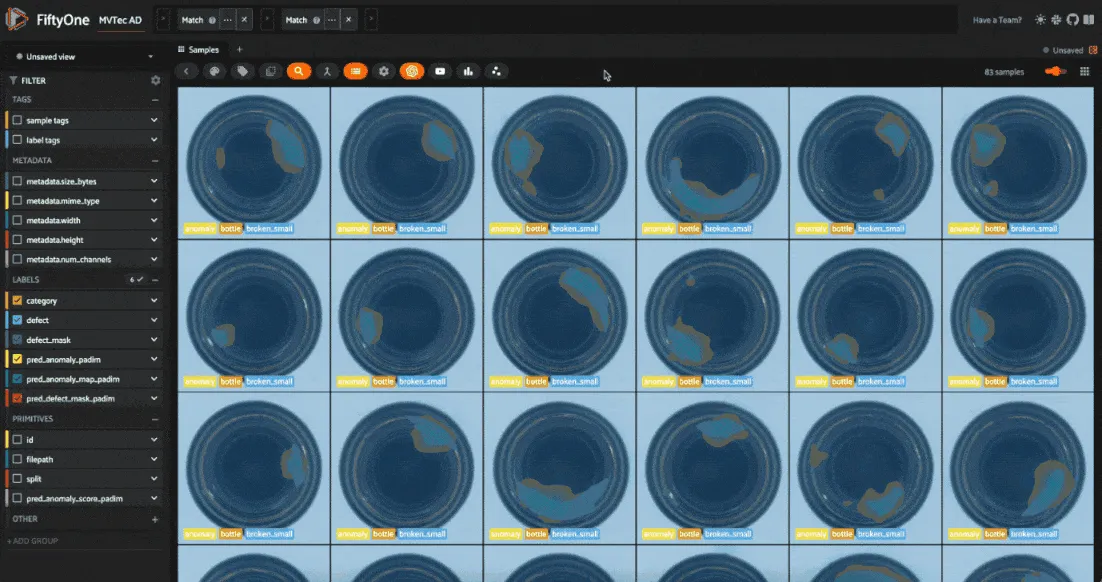

## Evaluate Anomaly Detection Models

We have an anomaly detection model, but how do we know if it's any good? For one, we can evaluate the model using metrics like precision, recall, and F1 score. FiftyOne's [Evaluation API](https://docs.voxel51.com/user_guide/evaluation.html#) makes this easy. We are going to evaluate the full-image classification performance of the model, as well as the segmentation performance.

We need to prepare our data for evaluation. First, we need to add null masks for the "normal" images to ensure the evaluation is fair:

In [ ]:
for sample in test_split.iter_samples(autosave=True, progress=True):
    if sample["defect"].label == "good":
        sample["defect_mask"] = fo.Segmentation(
            mask=np.zeros_like(sample["pred_defect_mask_padim"].mask)
        )

We also need to ensure consistency in naming/labels between ground truth and predictions. We'll rename all of our "good" images to "normal" and every type of anomaly to "anomaly":

In [39]:
old_labels = test_split.distinct("defect.label")
label_map = {label:"anomaly" for label in old_labels if label != "good"}
label_map["good"] = "normal"
mapped_view = test_split.map_labels("defect", label_map)

In [40]:
session.view = mapped_view.view()

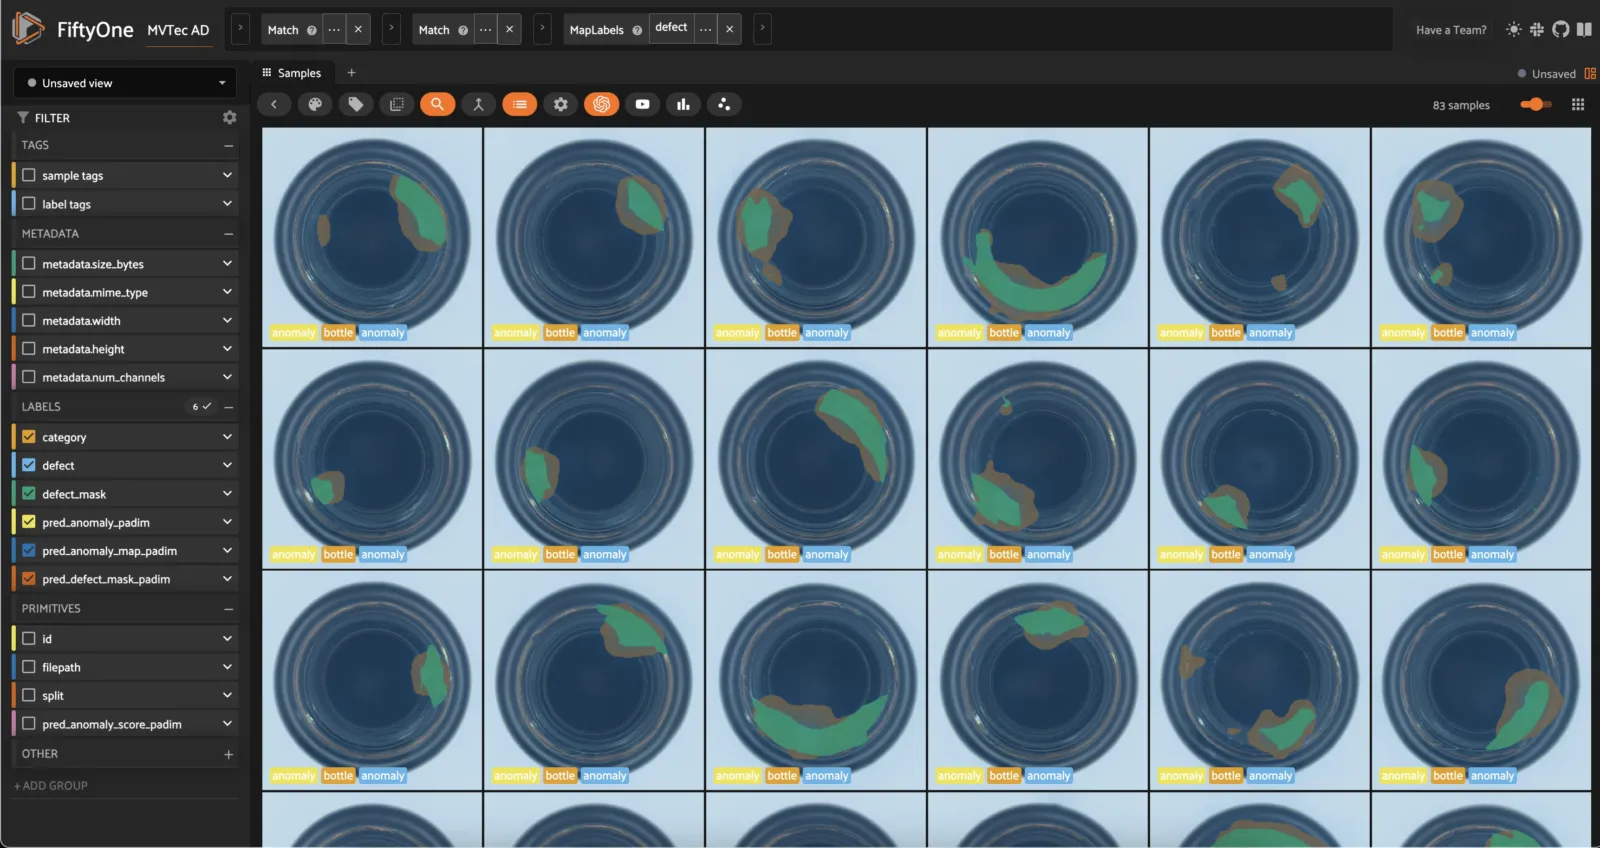

For classification, we'll use binary evaluation, with "normal" as the negative class and "anomaly" as the positive class:

In [41]:
eval_classif_padim = mapped_view.evaluate_classifications(
    "pred_anomaly_padim",
    gt_field="defect",
    eval_key="eval_classif_padim",
    method="binary",
    classes=["normal", "anomaly"],
)

In [42]:
eval_classif_padim.print_report()

              precision    recall  f1-score   support

      normal       0.95      0.90      0.92        20
     anomaly       0.97      0.98      0.98        63

    accuracy                           0.96        83
   macro avg       0.96      0.94      0.95        83
weighted avg       0.96      0.96      0.96        83



The model performs quite well on the classification task!

If we go back over to the app and sort by anomaly score, we can see that certain types of anomalies tend to have higher scores than others. In this example, `contamination` instances tend to have either very high or very low scores relative to `broken_small` and `broken_large`. When we put this model in production we might be more likely to miss certain types of anomalies. Other types of models, or ensembles of models, might be more robust to this!

For segmentation evaluation, we will only be interested in pixel values of $0$ (normal) and $255$ (anomaly), so we will filter our report for these "classes":

In [ ]:
eval_seg_padim = mapped_view.evaluate_segmentations(
    "pred_defect_mask_padim",
    gt_field="defect_mask",
    eval_key="eval_seg_padim",
)

In [44]:
eval_seg_padim.print_report(classes=[0, 255])

              precision    recall  f1-score   support

           0       0.99      0.96      0.98 63343269.0
         255       0.60      0.89      0.72 3886731.0

   micro avg       0.96      0.96      0.96 67230000.0
   macro avg       0.80      0.93      0.85 67230000.0
weighted avg       0.97      0.96      0.96 67230000.0



### Compare Anomaly Detection Models

Just because anomaly detection is unsupervised doesn't mean we can't compare models and choose the best one for our use case. We can train multiple models on the same data and compare their performance using metrics like F1 score, precision, and recall. We can also compare the models visually by inspecting the masks and heatmaps they generate.

Let's repeat the training process for the `PatchCore` model and compare the two models:

In [ ]:
## Train Patchcore model and run inference

model = Patchcore()

## This will take a little longer to train, but should still be < 5 minutes
inferencer = train_and_export_model(OBJECT, model)

run_inference(mapped_view, inferencer, "patchcore")

In [46]:
## Evaluate Patchcore model on classification task
eval_classif_patchcore = mapped_view.evaluate_classifications(
    "pred_anomaly_patchcore",
    gt_field="defect",
    eval_key="eval_classif_patchcore",
    method="binary",
    classes=["normal", "anomaly"],
)

eval_classif_patchcore.print_report()

              precision    recall  f1-score   support

      normal       0.95      1.00      0.98        20
     anomaly       1.00      0.98      0.99        63

    accuracy                           0.99        83
   macro avg       0.98      0.99      0.98        83
weighted avg       0.99      0.99      0.99        83



In [ ]:
eval_seg_patchcore = mapped_view.match(
    F("defect.label") == "anomaly"
).evaluate_segmentations(
    "pred_defect_mask_patchcore",
    gt_field="defect_mask",
    eval_key="eval_seg_patchcore",
)

In [48]:
eval_seg_patchcore.print_report(classes=[0, 255])

              precision    recall  f1-score   support

           0       0.99      0.95      0.97 47143269.0
         255       0.60      0.85      0.70 3886731.0

   micro avg       0.95      0.95      0.95 51030000.0
   macro avg       0.80      0.90      0.84 51030000.0
weighted avg       0.96      0.95      0.95 51030000.0



In [ ]:
session.view = mapped_view.shuffle().view()

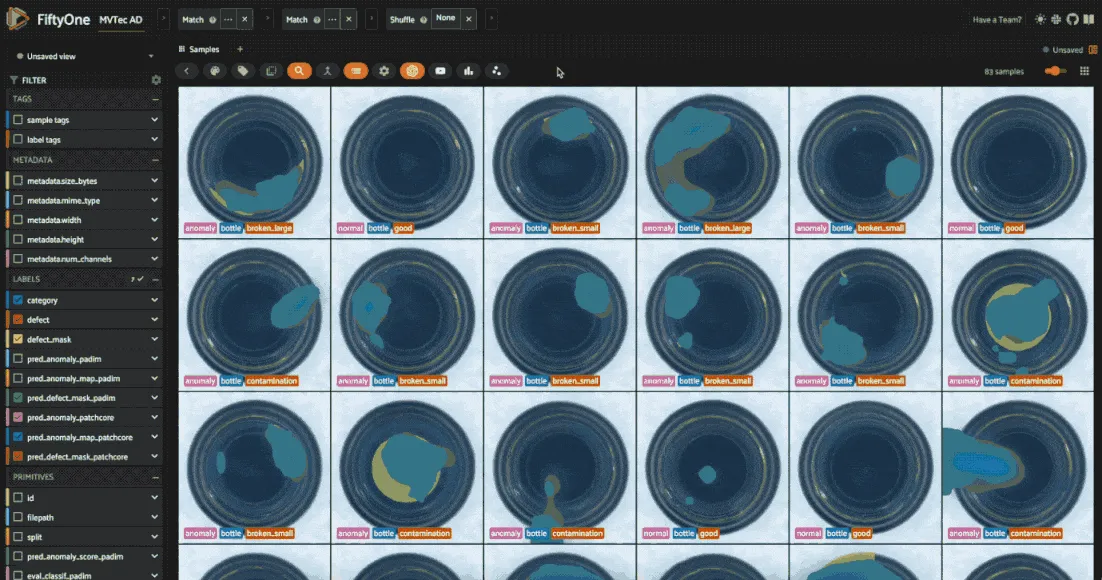

The metrics back up what we see in the app: PatchCore has much higher recall for the "anomaly" class, but lower precision. This means it's more likely to catch anomalies, but also more likely to make false positive predictions. After all, PatchCore is designed for "total recall" in industrial anomaly detection.

Looking at the heatmaps, we can also see what types of anomalies each model is better at detecting. An ensemble of the two models might be more robust to different types of anomalies.

## Test Data Augmentation Techniques

Beyond the anomaly detection algorithm itself, there are many other knobs we can turn to improve the performance of our model. These include:

- Backbone: The architecture of the model used for feature extraction
- Algorithm hyperparameters: Parameters specific to the anomaly detection algorithm. For PatchCore, this includes `coreset_sampling_ratio` and `num_neighbors`.
- Data augmentation: Techniques to artificially increase the size of the training set and improve the model's generalization.

This section briefly illustrates the role of data augmentation techniques in anomaly detection. We'll use [FiftyOne's Albumentations plugin](https://github.com/jacobmarks/fiftyone-albumentations-plugin) to test and visualize transformations on "good" samples from the dataset and then apply the same transformations (with `torchvision.transforms`) to the training images. 

The goal is to increase the diversity of the training set without changing the images so much that we verge into the "anomalous" territory.

First, let's install [Albumentations](https://albumentations.ai/docs/) and download the plugin:

In [ ]:
pip install -U albumentations

In [ ]:
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin

Refresh the FiftyOne App and hit the backtick key on your keyboard to open the operators list. Select `"augment_with_albumentations"` from the dropdown menu. Try applying transformations like `GaussianBlur`, and `ColorJitter`, and see how they affect the images. Use the `"view_last_albumentations_run"` operator to see the augmentations generated by the last run. Play around with the kernel size for blurring, and the brightness, contrast, and saturation values for color jittering. Depending on the object category, it might also make sense to apply 90 degree rotations, horizontal flips, and other transformations!

Once you're happy with the transformations, use the `"get_last_albumentations_run_info"` operator to see the transformations applied and their parameters. You can then use these with `torchvision.transforms` to augment the training images.

In [49]:
from torchvision.transforms.v2 import GaussianBlur, ColorJitter, Compose

In [50]:
transform = Compose([
    Resize(IMAGE_SIZE, antialias=True),
    GaussianBlur(kernel_size=3),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

In [ ]:
model = Patchcore()
augmented_inferencer = train_and_export_model(
    OBJECT, model, transform=transform
)

run_inference(mapped_view, augmented_inferencer, "patchcore_augmented")

session.view = mapped_view.view()

This is just a starting point for data augmentation. You can experiment with different transformations and parameters to see what works best for your dataset.

## Summary

In this walkthrough, we learned how to perform anomaly detection on visual data using FiftyOne and Anomalib. We trained two anomaly detection models, PaDiM and PatchCore, on the MVTec AD dataset and evaluated their performance using metrics like precision, recall, and F1 score. We also visualized the models' predictions using heatmaps and masks. Finally, we tested data augmentation techniques to improve the models' generalization.

If you want to dive deeper into unsupervised learning, check out these tutorials:

- [Visualizing Data with Dimensionality Reduction Techniques](https://docs.voxel51.com/tutorials/dimension_reduction.html)
- [Clustering Images with Embeddings](https://docs.voxel51.com/tutorials/clustering.html)

In [52]:
session.view = mapped_view.view()